In [1]:
profile = {
    "name": "John",
    "full_name": "John Doe",
    "user_profile_background": "Senior software engineer leading a team of 5 developers",
}

prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": 
    """
    You are responsible for ensuring John's communications and schedule are managed smoothly, and that John always has the right context for meetings, emails, and follow-ups. 
    You must actively use all tools provided to manage John's time and relationships effectively.
    Memory Management:

    - Use manage_memory to store any important information you learn about contacts, meeting outcomes, preferences, decisions, or tasks John needs to follow up on.

    - Use search_memory before performing tasks like writing emails or scheduling meetings to check for past context that may be relevant.

    Guidelines:

    - Do not ask John for the same information twice—use search_memory first.

    - Keep memory updated. After key events, always use manage_memory to store useful outcomes or notes.

    - Use memory to help John maintain continuity with contacts, follow up on discussions, and make well-informed decisions.

    Use all tools when appropriate to handle tasks efficiently and proactively.
    """
}

# Example incoming email
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [2]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model
from langchain_core.output_parsers import JsonOutputParser

llm = init_chat_model("google_genai:gemini-2.5-flash-lite-preview-06-17")
# llm = init_chat_model("google_genai:gemma-3-12b-it")

class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

# parser = JsonOutputParser(pydantic_object=Router)
llm_router = llm.with_structured_output(Router)

In [3]:
from prompts import triage_system_prompt, triage_user_prompt
from langchain_core.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"

@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

In [4]:
from langgraph.store.memory import InMemoryStore
from langmem import create_manage_memory_tool, create_search_memory_tool
from langchain_google_genai import GoogleGenerativeAIEmbeddings
_embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

store = InMemoryStore(
    index={"embed": _embeddings}
)

manage_memory_tool = create_manage_memory_tool(
    namespace=(
        "email_assistant", 
        "{langgraph_user_id}",
        "collection"
    )
)
search_memory_tool = create_search_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

In [5]:
print(manage_memory_tool.name)
print(manage_memory_tool.description)

manage_memory
Create, update, or delete a memory to persist across conversations.
Include the MEMORY ID when updating or deleting a MEMORY. Omit when creating a new MEMORY - it will be created for you.
Proactively call this tool when you:

1. Identify a new USER preference.
2. Receive an explicit USER request to remember something or otherwise alter your behavior.
3. Are working and want to record important context.
4. Identify that an existing MEMORY is incorrect or outdated.


In [6]:
print(manage_memory_tool.args)
print(search_memory_tool.name)
print(search_memory_tool.description)
print(search_memory_tool.args)

{'content': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'default': None, 'title': 'Content'}, 'action': {'default': 'create', 'enum': ['create', 'update', 'delete'], 'title': 'Action', 'type': 'string'}, 'id': {'anyOf': [{'format': 'uuid', 'type': 'string'}, {'type': 'null'}], 'default': None, 'title': 'Id'}}
search_memory
Search your long-term memories for information relevant to your current context.
{'query': {'title': 'Query', 'type': 'string'}, 'limit': {'default': 10, 'title': 'Limit', 'type': 'integer'}, 'offset': {'default': 0, 'title': 'Offset', 'type': 'integer'}, 'filter': {'anyOf': [{'additionalProperties': True, 'type': 'object'}, {'type': 'null'}], 'default': None, 'title': 'Filter'}}


In [7]:
agent_system_prompt_memory = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. search_memory - Search for any relevant information that may have been stored in memory
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

In [8]:
def create_prompt(state):
    return [
        {
            "role": "system", 
            "content": agent_system_prompt_memory.format(
                instructions=prompt_instructions["agent_instructions"], 
                **profile
            )
        }
    ] + state['messages']

In [9]:
from langgraph.prebuilt import create_react_agent

tools= [
    write_email, 
    schedule_meeting,
    check_calendar_availability,
    manage_memory_tool,
    search_memory_tool
]

response_agent = create_react_agent(
    "google_genai:gemini-2.5-flash-lite-preview-06-17",
    tools=tools,
    prompt=create_prompt,
    # Use this to ensure the store is passed to the agent 
    store=store
)

config = {"configurable": {"langgraph_user_id": "lance"}}

In [10]:
response = response_agent.invoke(
    {"messages": [{"role": "user", "content": "Jim is my friend"}]},
    config=config
)
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Jim is my friend
================================== Ai Message ==================================
Tool Calls:
  manage_memory (d407b777-a420-47af-9e37-30434c03d58f)
 Call ID: d407b777-a420-47af-9e37-30434c03d58f
  Args:
    content: Jim is my friend
    action: create
================================= Tool Message =================================
Name: manage_memory

created memory b6896237-8d12-4774-ad59-29704ba4d8d5
================================== Ai Message ==================================
Tool Calls:
  manage_memory (7702080b-be4e-4e35-a769-582070d2d096)
 Call ID: 7702080b-be4e-4e35-a769-582070d2d096
  Args:
    content: Jim is a friend of John. They were discussing the upcoming project and Jim's concerns about the timeline.
    action: create
================================= Tool Message =================================
Name: manage_memory

created memory d3cfe03d-24f8-4c94-a5d2-98ab09746d1e


In [11]:
response = response_agent.invoke(
    {"messages": [{"role": "user", "content": "who is jim?"}]},
    config=config
)
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

who is jim?
================================== Ai Message ==================================
Tool Calls:
  search_memory (101bbfa8-ff4b-4d1f-b369-6e46e665c2de)
 Call ID: 101bbfa8-ff4b-4d1f-b369-6e46e665c2de
  Args:
    query: who is Jim
================================= Tool Message =================================
Name: search_memory

[{"namespace":["email_assistant","lance","collection"],"key":"d3cfe03d-24f8-4c94-a5d2-98ab09746d1e","value":{"content":"Jim is a friend of John. They were discussing the upcoming project and Jim's concerns about the timeline."},"created_at":"2025-07-07T06:46:13.927396+00:00","updated_at":"2025-07-07T06:46:13.927396+00:00","score":0.5575582727471428},{"namespace":["email_assistant","lance","collection"],"key":"b6896237-8d12-4774-ad59-29704ba4d8d5","value":{"content":"Jim is my friend"},"created_at":"2025-07-07T06:46:12.692751+00:00","updated_at":"2025-07-07T06:46:12.692751+

In [12]:
store.list_namespaces()

[('email_assistant', 'lance', 'collection')]

In [13]:
store.search(('email_assistant', 'lance', 'collection'))

[Item(namespace=['email_assistant', 'lance', 'collection'], key='b6896237-8d12-4774-ad59-29704ba4d8d5', value={'content': 'Jim is my friend'}, created_at='2025-07-07T06:46:12.692751+00:00', updated_at='2025-07-07T06:46:12.692751+00:00', score=None),
 Item(namespace=['email_assistant', 'lance', 'collection'], key='d3cfe03d-24f8-4c94-a5d2-98ab09746d1e', value={'content': "Jim is a friend of John. They were discussing the upcoming project and Jim's concerns about the timeline."}, created_at='2025-07-07T06:46:13.927396+00:00', updated_at='2025-07-07T06:46:13.927396+00:00', score=None)]

In [14]:
store.search(('email_assistant', 'lance', 'collection'), query="jim")

[Item(namespace=['email_assistant', 'lance', 'collection'], key='d3cfe03d-24f8-4c94-a5d2-98ab09746d1e', value={'content': "Jim is a friend of John. They were discussing the upcoming project and Jim's concerns about the timeline."}, created_at='2025-07-07T06:46:13.927396+00:00', updated_at='2025-07-07T06:46:13.927396+00:00', score=0.5685096630147286),
 Item(namespace=['email_assistant', 'lance', 'collection'], key='b6896237-8d12-4774-ad59-29704ba4d8d5', value={'content': 'Jim is my friend'}, created_at='2025-07-07T06:46:12.692751+00:00', updated_at='2025-07-07T06:46:12.692751+00:00', score=0.512820820654244)]

## Create agent with semantic memory

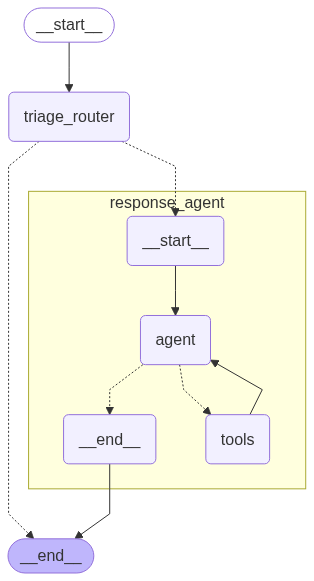

In [15]:
from langgraph.graph import add_messages
from typing_extensions import TypedDict, Literal, Annotated

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

def triage_router(state: State) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"],
        examples=None
    )
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", response_agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile(store=store)

display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [16]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

for m in response["messages"]:
    m.pretty_print()

📧 Classification: RESPOND - This email requires a response
================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
================================== Ai Message ==================================
Tool Calls:
  search_memory (f2c18a15-63f9-4a70-b988-0fd51fc89dd8)
 Call ID: f2c18a15-63f9-4a70-b988-0fd51fc89dd8
  Args:
    query: Alice Smith API documentation auth endpoints
================================= Tool Message =================================
Name: search_memory

### Try a follow-up email

In [17]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Follow up",
    "email_thread": """Hi John,

Any update on my previous ask?""",
}

response = email_agent.invoke({"email_input": email_input}, config=config)

📧 Classification: RESPOND - This email requires a response


In [18]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Follow up', 'email_thread': 'Hi John,\n\nAny update on my previous ask?'}
================================== Ai Message ==================================
Tool Calls:
  write_email (281be8e4-fed5-4dc2-afc6-1a00c01c091d)
 Call ID: 281be8e4-fed5-4dc2-afc6-1a00c01c091d
  Args:
    to: Alice Smith <alice.smith@company.com>
    content: Hi Alice,

I'm still working on your request and will get back to you as soon as I have an update.

Best,
John Doe
    subject: Follow up
================================= Tool Message =================================
Name: write_email

Email sent to Alice Smith <alice.smith@company.com> with subject 'Follow up'
================================== Ai Message ==================================

I've responded to Alice's email to let her know you're still 